### Imports 

In [1]:
import os

import numpy as np
import plotly.express as px
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

from data import PROJECT_ROOT_FOLDER, PROJECT_PROCESSED_DATA_FOLDER
from data_processing.data_loaders.raw_data_loaders import DataLoaders
from enums.EColor import EColor

### Configurations

In [2]:
full_graphs = False
release = False
x_log_scale = True
cities_data_date = '2021-01-12'
cases_signal = "Active_cases"  # {"Active_cases", "Cumulative_verified_cases"}
size_key = "population_60+"
x_data_date = "12/1/21"
y_data_date = "12/1/21"
x_key = "{} per 10,000 people - {}".format(cases_signal.replace('_', ' '), x_data_date)
y_key = "60+ Vaccination [%] - {}".format(y_data_date)
color_key = "VNR"
color_scale = [EColor.GREEN,
               EColor.ORANGE,
               EColor.RED]

### Raw data

In [3]:
# Cases data - x
cities_df_raw = DataLoaders.get_cases_by_city()

# Vaccination data - y
vaccination_df_raw = DataLoaders.get_vaccinations_by_age_and_city()

# Population data
pop_df_raw = DataLoaders.get_population_age_groups_by_city()

# Social-Economic Rank data
rank_df_raw = DataLoaders.get_socioeconomic_rank_by_city()

### Pre-Processing

#### Vaccinations by age and city data pre-processing

##### Raw Data

In [4]:
vaccination_df_raw

,City_Name,16-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+,missing_data
0,אבו ג'ווייעד (שבט),NaN,< 15,NaN,< 15,< 15,< 15,< 15,NaN,< 15,NaN
1,אבו גוש,< 15,93,144,146,186,236,89,24,< 15,< 15
2,אבו סנאן,< 15,124,141,146,167,274,149,37,< 15,NaN
3,אבו קורינאת (שבט),NaN,NaN,< 15,NaN,NaN,< 15,< 15,< 15,NaN,NaN
4,אבו רובייעה (שבט),NaN,< 15,NaN,< 15,< 15,< 15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
274,תל אביב - יפו,304,3750,8608,10058,11861,21616,20534,10725,3660,31
275,תל מונד,27,184,146,387,708,692,390,170,70,< 15
276,תל שבע,< 15,38,67,65,81,93,42,< 15,NaN,< 15
277,תפרח,< 15,< 15,< 15,< 15,19,43,25,< 15,< 15,NaN


In [5]:
vaccination_df = vaccination_df_raw.copy()
vaccination_df["drop_row"] = False
for index, row in vaccination_df.iterrows():
    cnt = int(row["60-69"] in ['< 15']) + \
          int(row["70-79"] in ['< 15']) + \
          int(row["80-89"] in ['< 15']) + \
          int(row["90+"] in ['< 15'])
    if cnt > 1:
        vaccination_df.loc[index, "drop_row"] = True
vaccination_df = vaccination_df[vaccination_df.drop_row == False]
vaccination_df = vaccination_df.drop("drop_row", 1)

vaccination_df.replace('< 15', 1, inplace=True)
vaccination_df.replace(np.nan, -100, inplace=True)
vaccination_df.set_index('City_Name', inplace=True)
vaccination_df = vaccination_df.astype('float').astype('int')
vaccination_df.replace(-100, np.nan, inplace=True)
vaccination_df.reset_index(inplace=True)

In [6]:
# Calculating 60+ vaccinations
vaccination_df["vaccination_60+"] = vaccination_df["60-69"].fillna(0) + \
                                    vaccination_df["70-79"].fillna(0) + \
                                    vaccination_df["80-89"].fillna(0) + \
                                    vaccination_df["90+"].fillna(0)

##### Pre-processed data 

In [7]:
vaccination_df

,City_Name,16-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+,missing_data,vaccination_60+
0,אבו גוש,1.0,93.0,144.0,146.0,186.0,236.0,89.0,24.0,1.0,1.0,350.0
1,אבו סנאן,1.0,124.0,141.0,146.0,167.0,274.0,149.0,37.0,1.0,NaN,461.0
2,אבו רובייעה (שבט),NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0
3,אבו רוקייק (שבט),1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0
4,אבו תלול,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
229,שפרעם,28.0,478.0,606.0,613.0,904.0,1114.0,608.0,247.0,34.0,1.0,2003.0
230,שתולים,1.0,24.0,19.0,50.0,106.0,123.0,39.0,17.0,1.0,1.0,180.0
231,תל אביב - יפו,304.0,3750.0,8608.0,10058.0,11861.0,21616.0,20534.0,10725.0,3660.0,31.0,56535.0
232,תל מונד,27.0,184.0,146.0,387.0,708.0,692.0,390.0,170.0,70.0,1.0,1322.0


In [8]:
# Filtering relevant vaccination data
vaccination_60_plus = vaccination_df[["City_Name", "vaccination_60+"]]
vaccination_60_plus = vaccination_60_plus.replace(np.nan, 0)
vaccination_60_plus

,City_Name,vaccination_60+
0,אבו גוש,350.0
1,אבו סנאן,461.0
2,אבו רובייעה (שבט),1.0
3,אבו רוקייק (שבט),1.0
4,אבו תלול,1.0
...,...,...
229,שפרעם,2003.0
230,שתולים,180.0
231,תל אביב - יפו,56535.0
232,תל מונד,1322.0


#### Socioeconomic rank data pre-processing

##### Raw data

In [9]:
rank_df_raw

,UID,name_h,name_e,Index,Rank
0,NaN,נווה מדבר,NEVE MIDBAR,-2.815,1
1,1192.0,ערערה-בנגב,AR'ARA-BANEGEV,-2.535,2
2,1054.0,תל שבע,TEL SHEVA,-2.329,3
3,1059.0,כסיפה,KUSEIFE,-2.255,4
4,3797.0,מודיעין עילית,MODI'IN ILLIT,-2.234,5
...,...,...,...,...,...
250,1224.0,כוכב יאיר,KOKHAV YA'IR,1.809,251
251,666.0,עומר,OMER,1.900,252
252,1271.0,להבים,LEHAVIM,1.989,253
253,267.0,כפר שמריהו,KEFAR SHEMARYAHU,2.068,254


In [27]:
rank_df = rank_df_raw.copy()
rank_df = rank_df.dropna()
rank_df['Rank'] = rank_df['Rank'].astype('float').astype('int')
rank_df['UID'] = rank_df['UID'].astype('float').astype('int')

##### Pre-processed data

In [28]:
rank_df

,UID,name_h,name_e,Index,Rank
1,1192,ערערה-בנגב,AR'ARA-BANEGEV,-2.535,2
2,1054,תל שבע,TEL SHEVA,-2.329,3
3,1059,כסיפה,KUSEIFE,-2.255,4
4,3797,מודיעין עילית,MODI'IN ILLIT,-2.234,5
5,1286,שגב-שלום,SEGEV-SHALOM,-2.215,6
...,...,...,...,...,...
250,1224,כוכב יאיר,KOKHAV YA'IR,1.809,251
251,666,עומר,OMER,1.900,252
252,1271,להבים,LEHAVIM,1.989,253
253,267,כפר שמריהו,KEFAR SHEMARYAHU,2.068,254


#### Population by city and age group data pre-processing

##### Raw data

In [29]:
pop_df_raw

,UID,total_pop,pop_4-0,pop_9-5,pop_14-10,pop_19-15,pop_24-20,pop_29-25,pop_34-30,pop_39-35,pop_44-40,pop_49-45,pop_54-50,pop_59-55,pop_64-60,pop_69-65,pop_74-70,pop_79-75,pop_84-80,pop_+85
0,3000,936425,116731,103618,93117,88676,82568,71915,59361,51784,44726,39906,34786,32747,29911,26812,22330,13874,11594,11970
1,70,225939,21352,20376,18129,16962,16176,13641,13095,12832,13050,12929,11603,11402,10884,10092,9131,5309,5199,3776
2,9000,209687,17990,16209,14202,13136,14913,15069,15024,13587,11897,11273,10642,11247,11625,10706,8507,4784,4914,3960
3,6100,204639,34701,28025,22306,21449,17450,15001,12924,10609,7302,6161,5201,4803,4808,4714,3820,1897,1598,1874
4,4000,285316,20466,19564,17167,15925,18577,19073,19524,18166,17158,16410,14746,14607,15379,16224,15825,8613,8769,9123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,1334,393,49,42,22,42,37,49,35,24,18,16,23,12,14,6,..,5,0,0
1214,990,643,71,69,84,81,69,54,31,33,38,30,29,23,14,9,5,4,0,0
1215,539,1212,140,132,114,161,141,115,85,65,68,48,50,40,21,18,5,5,..,..
1216,540,1195,103,105,80,86,92,109,75,88,86,74,56,70,58,38,35,22,12,8


In [30]:
# pre-processing population data
pop_df = pop_df_raw.copy()
pop_df.replace('..', -100, inplace=True)
pop_df = pop_df.astype('float').astype('int')
pop_df.replace(-100, 0, inplace=True)

# Calculating 60+ population
pop_df["population_60+"] = pop_df["pop_64-60"] + \
                           pop_df["pop_69-65"] + \
                           pop_df["pop_74-70"] + \
                           pop_df["pop_79-75"] + \
                           pop_df["pop_84-80"] + \
                           pop_df["pop_+85"]

##### Pre-processed data

In [31]:
pop_df

,UID,total_pop,pop_4-0,pop_9-5,pop_14-10,pop_19-15,pop_24-20,pop_29-25,pop_34-30,pop_39-35,...,pop_49-45,pop_54-50,pop_59-55,pop_64-60,pop_69-65,pop_74-70,pop_79-75,pop_84-80,pop_+85,population_60+
0,3000,936425,116731,103618,93117,88676,82568,71915,59361,51784,...,39906,34786,32747,29911,26812,22330,13874,11594,11970,116491
1,70,225939,21352,20376,18129,16962,16176,13641,13095,12832,...,12929,11603,11402,10884,10092,9131,5309,5199,3776,44391
2,9000,209687,17990,16209,14202,13136,14913,15069,15024,13587,...,11273,10642,11247,11625,10706,8507,4784,4914,3960,44496
3,6100,204639,34701,28025,22306,21449,17450,15001,12924,10609,...,6161,5201,4803,4808,4714,3820,1897,1598,1874,18711
4,4000,285316,20466,19564,17167,15925,18577,19073,19524,18166,...,16410,14746,14607,15379,16224,15825,8613,8769,9123,73933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,1334,393,49,42,22,42,37,49,35,24,...,16,23,12,14,6,0,5,0,0,25
1214,990,643,71,69,84,81,69,54,31,33,...,30,29,23,14,9,5,4,0,0,32
1215,539,1212,140,132,114,161,141,115,85,65,...,48,50,40,21,18,5,5,0,0,49
1216,540,1195,103,105,80,86,92,109,75,88,...,74,56,70,58,38,35,22,12,8,173


In [32]:
# Filtering relevant population data
pop_df = pop_df[["UID", "population_60+", "total_pop"]]
pop_df

,UID,population_60+,total_pop
0,3000,116491,936425
1,70,44391,225939
2,9000,44496,209687
3,6100,18711,204639
4,4000,73933,285316
...,...,...,...
1213,1334,25,393
1214,990,32,643
1215,539,49,1212
1216,540,173,1195


#### COVID-19 active cases by city data pre-processing

##### Raw data

In [33]:
cities_df_raw

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated
0,אבו ג'ווייעד (שבט),967,2020-03-11,0,0,0,0,0,0
1,אבו ג'ווייעד (שבט),967,2020-03-12,0,0,0,0,0,0
2,אבו ג'ווייעד (שבט),967,2020-03-13,0,0,0,0,0,0
3,אבו ג'ווייעד (שבט),967,2020-03-14,0,0,0,0,0,0
4,אבו ג'ווייעד (שבט),967,2020-03-15,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
85927,תקוע,3563,2021-01-08,108,79,0,4595,4545,333
85928,תקוע,3563,2021-01-09,109,81,0,4620,4570,333
85929,תקוע,3563,2021-01-10,113,85,0,4687,4637,345
85930,תקוע,3563,2021-01-11,115,87,0,4804,4753,359


In [34]:
cities_df = cities_df_raw.copy()
cities_df_at_date = cities_df[cities_df['Date'] == cities_data_date].copy()
cities_df_at_date

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated
307,אבו ג'ווייעד (שבט),967,2021-01-12,<15,<15,0,647,645,17
615,אבו גוש,472,2021-01-12,631,478,<15,10056,9719,957
923,אבו סנאן,473,2021-01-12,864,747,<15,12506,11818,1065
1231,אבו קורינאת (שבט),968,2021-01-12,<15,<15,0,667,667,<15
1539,אבו רובייעה (שבט),966,2021-01-12,<15,<15,0,936,928,<15
...,...,...,...,...,...,...,...,...,...
84699,תל אביב - יפו,5000,2021-01-12,15942,13587,202,481191,464651,93499
85007,תל מונד,154,2021-01-12,317,280,<15,13165,12960,2848
85315,תל שבע,1054,2021-01-12,243,218,<15,6555,6388,427
85623,תפרח,709,2021-01-12,418,358,<15,2866,2721,128


In [35]:
# Pre-processing relevant cities data
columns_to_int = ['Cumulative_verified_cases',
                  'Cumulated_recovered', 
                  'Cumulated_deaths', 
                  'Cumulated_vaccinated']

columns_to_impute = columns_to_int

for col in columns_to_impute: 
    cities_df_at_date[col] = cities_df_at_date[col].replace('<15', 1)
    
for col in columns_to_int: 
    cities_df_at_date[col] =  cities_df_at_date[col].astype('float').astype('int')

# Calculating active cases
cities_df_at_date['Active_cases'] = cities_df_at_date['Cumulative_verified_cases'] - \
                                    cities_df_at_date['Cumulated_recovered'] - \
                                    cities_df_at_date['Cumulated_deaths']

# Fixing active cases mistakes
cities_df_at_date.loc[cities_df_at_date['Active_cases'] < 0, 'Active_cases'] = 0

##### Pre-processed data

In [36]:
cities_df_at_date

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated,Active_cases
307,אבו ג'ווייעד (שבט),967,2021-01-12,1,1,0,647,645,17,0
615,אבו גוש,472,2021-01-12,631,478,1,10056,9719,957,152
923,אבו סנאן,473,2021-01-12,864,747,1,12506,11818,1065,116
1231,אבו קורינאת (שבט),968,2021-01-12,1,1,0,667,667,1,0
1539,אבו רובייעה (שבט),966,2021-01-12,1,1,0,936,928,1,0
...,...,...,...,...,...,...,...,...,...,...
84699,תל אביב - יפו,5000,2021-01-12,15942,13587,202,481191,464651,93499,2153
85007,תל מונד,154,2021-01-12,317,280,1,13165,12960,2848,36
85315,תל שבע,1054,2021-01-12,243,218,1,6555,6388,427,24
85623,תפרח,709,2021-01-12,418,358,1,2866,2721,128,59


#### Merging processed data 

In [37]:
# We start from the COVID-19 active cases data 
bubble_table = cities_df_at_date.copy()

# We first merge it with the population data 
bubble_table = bubble_table.merge(pop_df, left_on="City_Code", right_on="UID")
bubble_table

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated,Active_cases,UID,population_60+,total_pop
0,אבו גוש,472,2021-01-12,631,478,1,10056,9719,957,152,472,724,7698
1,אבו סנאן,473,2021-01-12,864,747,1,12506,11818,1065,116,473,1446,14099
2,אבו תלול,1375,2021-01-12,1,1,0,267,266,1,0,1375,62,2023
3,אבטין,652,2021-01-12,132,111,0,1926,1845,264,21,652,224,2835
4,אבן יהודה,182,2021-01-12,380,323,1,16875,16395,3167,56,182,2519,13826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,תל אביב - יפו,5000,2021-01-12,15942,13587,202,481191,464651,93499,2153,5000,90283,460613
264,תל מונד,154,2021-01-12,317,280,1,13165,12960,2848,36,154,1577,13144
265,תל שבע,1054,2021-01-12,243,218,1,6555,6388,427,24,1054,619,20808
266,תפרח,709,2021-01-12,418,358,1,2866,2721,128,59,709,162,2178


In [38]:
# Merging vaccination data
bubble_table = bubble_table.merge(vaccination_60_plus, on="City_Name")
bubble_table

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated,Active_cases,UID,population_60+,total_pop,vaccination_60+
0,אבו גוש,472,2021-01-12,631,478,1,10056,9719,957,152,472,724,7698,350.0
1,אבו סנאן,473,2021-01-12,864,747,1,12506,11818,1065,116,473,1446,14099,461.0
2,אבו תלול,1375,2021-01-12,1,1,0,267,266,1,0,1375,62,2023,1.0
3,אבטין,652,2021-01-12,132,111,0,1926,1845,264,21,652,224,2835,120.0
4,אבן יהודה,182,2021-01-12,380,323,1,16875,16395,3167,56,182,2519,13826,1757.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,שפרעם,8800,2021-01-12,2956,2442,25,42461,40760,4727,489,8800,4492,42137,2003.0
222,שתולים,763,2021-01-12,137,117,0,2210,2140,391,20,763,256,2116,180.0
223,תל אביב - יפו,5000,2021-01-12,15942,13587,202,481191,464651,93499,2153,5000,90283,460613,56535.0
224,תל מונד,154,2021-01-12,317,280,1,13165,12960,2848,36,154,1577,13144,1322.0


In [39]:
rank_df

,UID,name_h,name_e,Index,Rank
1,1192,ערערה-בנגב,AR'ARA-BANEGEV,-2.535,2
2,1054,תל שבע,TEL SHEVA,-2.329,3
3,1059,כסיפה,KUSEIFE,-2.255,4
4,3797,מודיעין עילית,MODI'IN ILLIT,-2.234,5
5,1286,שגב-שלום,SEGEV-SHALOM,-2.215,6
...,...,...,...,...,...
250,1224,כוכב יאיר,KOKHAV YA'IR,1.809,251
251,666,עומר,OMER,1.900,252
252,1271,להבים,LEHAVIM,1.989,253
253,267,כפר שמריהו,KEFAR SHEMARYAHU,2.068,254


In [40]:
# Merging Social-economic rank data
bubble_table = bubble_table.merge(rank_df, on="UID")
bubble_table

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated,Active_cases,UID,population_60+,total_pop,vaccination_60+,name_h,name_e,Index,Rank
0,אבו גוש,472,2021-01-12,631,478,1,10056,9719,957,152,472,724,7698,350.0,אבו גוש,ABU GHOSH,-0.783,65
1,אבו סנאן,473,2021-01-12,864,747,1,12506,11818,1065,116,473,1446,14099,461.0,אבו סנאן,ABU SINAN,-0.792,63
2,אבן יהודה,182,2021-01-12,380,323,1,16875,16395,3167,56,182,2519,13826,1757.0,אבן יהודה,EVEN YEHUDA,1.499,243
3,אום אל-פחם,2710,2021-01-12,4246,3822,36,41749,39343,4788,388,2710,3960,56109,1681.0,אום אל-פחם,UMM AL-FAHM,-1.413,17
4,אופקים,31,2021-01-12,2089,1865,1,37716,36682,4449,223,31,3958,30662,1906.0,אופקים,OFAQIM,-0.703,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,שעב,538,2021-01-12,516,452,1,7516,7311,512,63,538,481,7061,169.0,שעב,SHA'AB,-1.232,22
180,שפרעם,8800,2021-01-12,2956,2442,25,42461,40760,4727,489,8800,4492,42137,2003.0,שפרעם,SHEFAR'AM,-0.782,66
181,תל אביב - יפו,5000,2021-01-12,15942,13587,202,481191,464651,93499,2153,5000,90283,460613,56535.0,תל אביב -יפו,TEL AVIV - YAFO,1.113,215
182,תל מונד,154,2021-01-12,317,280,1,13165,12960,2848,36,154,1577,13144,1322.0,תל מונד,TEL MOND,1.367,236


### Data analysis

In [41]:
# Calculating x
bubble_table[x_key] = \
    bubble_table[cases_signal] / (bubble_table["total_pop"] / 10000)
bubble_table[x_key].describe()

count    184.000000
mean      82.618448
std       60.276377
min        9.144111
25%       46.332399
50%       64.626349
75%       99.831532
max      420.431037
Name: Active cases per 10,000 people - 12/1/21, dtype: float64

In [42]:
# Calculating y
bubble_table[y_key] = \
    (bubble_table["vaccination_60+"] / (bubble_table["population_60+"])) * 100

bubble_table[y_key].describe()

count    184.000000
mean      54.604789
std       16.603150
min        5.428571
25%       43.476621
50%       54.880036
75%       66.711744
max       90.929705
Name: 60+ Vaccination [%] - 12/1/21, dtype: float64

In [43]:
# Calculating Vaccinations Need Ratio (VNR)
bubble_table["VNR"] = bubble_table[x_key] / \
                      bubble_table[y_key]
bubble_table["VNR"].describe()

count    184.000000
mean       1.713459
std        1.375241
min        0.149755
25%        0.756856
50%        1.231853
75%        2.414659
max        8.064555
Name: VNR, dtype: float64

In [44]:
# Calculating color coding 
low_color = bubble_table[color_key].quantile(0.2)
high_color = bubble_table[color_key].quantile(0.8)

### Plot Results 

In [45]:
show_table = bubble_table.copy()
show_table

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated,Active_cases,...,population_60+,total_pop,vaccination_60+,name_h,name_e,Index,Rank,"Active cases per 10,000 people - 12/1/21",60+ Vaccination [%] - 12/1/21,VNR
0,אבו גוש,472,2021-01-12,631,478,1,10056,9719,957,152,...,724,7698,350.0,אבו גוש,ABU GHOSH,-0.783,65,197.453884,48.342541,4.084475
1,אבו סנאן,473,2021-01-12,864,747,1,12506,11818,1065,116,...,1446,14099,461.0,אבו סנאן,ABU SINAN,-0.792,63,82.275339,31.881051,2.580697
2,אבן יהודה,182,2021-01-12,380,323,1,16875,16395,3167,56,...,2519,13826,1757.0,אבן יהודה,EVEN YEHUDA,1.499,243,40.503399,69.749901,0.580695
3,אום אל-פחם,2710,2021-01-12,4246,3822,36,41749,39343,4788,388,...,3960,56109,1681.0,אום אל-פחם,UMM AL-FAHM,-1.413,17,69.151117,42.449495,1.629021
4,אופקים,31,2021-01-12,2089,1865,1,37716,36682,4449,223,...,3958,30662,1906.0,אופקים,OFAQIM,-0.703,73,72.728459,48.155634,1.510279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,שעב,538,2021-01-12,516,452,1,7516,7311,512,63,...,481,7061,169.0,שעב,SHA'AB,-1.232,22,89.222490,35.135135,2.539409
180,שפרעם,8800,2021-01-12,2956,2442,25,42461,40760,4727,489,...,4492,42137,2003.0,שפרעם,SHEFAR'AM,-0.782,66,116.050027,44.590383,2.602580
181,תל אביב - יפו,5000,2021-01-12,15942,13587,202,481191,464651,93499,2153,...,90283,460613,56535.0,תל אביב -יפו,TEL AVIV - YAFO,1.113,215,46.742059,62.619762,0.746443
182,תל מונד,154,2021-01-12,317,280,1,13165,12960,2848,36,...,1577,13144,1322.0,תל מונד,TEL MOND,1.367,236,27.388923,83.830057,0.326720


In [47]:
if not full_graphs:
    # remove cities where 60+ population is less then 1000
    show_table.drop(show_table.loc[show_table['population_60+'] < 1000].index, inplace=True)
    if cases_signal is "Active_cases":
        chosen_x_range = [20, 300]
    elif cases_signal is "Cumulative_verified_cases":
        chosen_x_range = [180, 1700]
    else:
        print("x_range was not specified. using None.")
    chosen_y_range = [21, 91]
else:
    chosen_x_range = None
    chosen_y_range = None

show_table

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,Cumulated_vaccinated,Active_cases,...,population_60+,total_pop,vaccination_60+,name_h,name_e,Index,Rank,"Active cases per 10,000 people - 12/1/21",60+ Vaccination [%] - 12/1/21,VNR
1,אבו סנאן,473,2021-01-12,864,747,1,12506,11818,1065,116,...,1446,14099,461.0,אבו סנאן,ABU SINAN,-0.792,63,82.275339,31.881051,2.580697
2,אבן יהודה,182,2021-01-12,380,323,1,16875,16395,3167,56,...,2519,13826,1757.0,אבן יהודה,EVEN YEHUDA,1.499,243,40.503399,69.749901,0.580695
3,אום אל-פחם,2710,2021-01-12,4246,3822,36,41749,39343,4788,388,...,3960,56109,1681.0,אום אל-פחם,UMM AL-FAHM,-1.413,17,69.151117,42.449495,1.629021
4,אופקים,31,2021-01-12,2089,1865,1,37716,36682,4449,223,...,3958,30662,1906.0,אופקים,OFAQIM,-0.703,73,72.728459,48.155634,1.510279
5,אור יהודה,2400,2021-01-12,2441,2186,22,41394,38856,6291,233,...,6743,36813,3941.0,אור יהודה,OR YEHUDA,0.120,136,63.292859,58.445796,1.082933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,שוהם,1304,2021-01-12,693,600,1,24324,23741,5206,92,...,2566,21045,2289.0,שוהם,SHOHAM,1.671,248,43.715847,89.204988,0.490061
178,שלומי,812,2021-01-12,293,243,1,8052,7829,1370,49,...,1129,6511,661.0,שלומי,SHELOMI,0.188,141,75.257257,58.547387,1.285408
180,שפרעם,8800,2021-01-12,2956,2442,25,42461,40760,4727,489,...,4492,42137,2003.0,שפרעם,SHEFAR'AM,-0.782,66,116.050027,44.590383,2.602580
181,תל אביב - יפו,5000,2021-01-12,15942,13587,202,481191,464651,93499,2153,...,90283,460613,56535.0,תל אביב -יפו,TEL AVIV - YAFO,1.113,215,46.742059,62.619762,0.746443


In [48]:
# remove text of cities with total population less then 30k
show_table["text"] = show_table["name_e"]
show_table.loc[(show_table.total_pop < 30000), "text"] = ""

#### 60+ Vaccination vs. Active cases per 10,000 people

In [51]:
fig = px.scatter(show_table,
                 x=x_key,
                 y=y_key,
                 size=size_key,
                 color=color_key,
                 hover_name="name_e",
                 hover_data={'Cumulated_vaccinated': ':.0f',
                             'population_60+': ':.0f',
                             'vaccination_60+': ':.0f'},
                 log_x=x_log_scale,
                 opacity=None,  # between 0 to 1
                 range_x=chosen_x_range,
                 range_y=chosen_y_range,
                 size_max=120,
                 height=1000,
                 text="text",
                 # template='plotly_dark',
                 color_continuous_scale=color_scale,
                 range_color=[low_color, high_color])

# Set titles
fig.update_layout(title="<b>60+ Vaccination vs. {} <br>"
                        "Size = {}, Color = Vaccination Need Ratio (VNR)<b>"
                  .format(x_key.replace('_', ' ').capitalize().split('-')[0],
                          size_key.replace('_', ' ').capitalize()),
                  title_x=0.5,
                  font=dict(
                      size=11,
                  ),
                  xaxis_title='<b>' + "{}".format(
                      x_key.replace('_', ' ')) + ' (Logarithmic Scale)' if x_log_scale else '' + '<b>',
                  yaxis_title='<b>' + y_key + '<b>',
                  margin=dict(r=0, l=0, b=0, t=150),
                  template="plotly_white"
                  )

if release:
    # Release hover template
    fig.data[0].update(hovertemplate='<b>%{hovertext}</b><br><br>' +
                                     'Vaccination Need Ratio' + ' = %{marker.color:.3f}<br>')
else:
    # Full hover template
    fig.data[0].update(hovertemplate='<b>%{hovertext}</b><br><br>' +
                                     'Accumulated Cases per 10,000' + ' = %{x: .0f}<br>' +
                                     '60+ Vaccination' + ' = %{y: .0f}%<br>' +
                                     '<br>' +
                                     'Accumulated 60+ Vaccinated' + ' = %{customdata[2]: .0f}<br>' +
                                     'Population over 60' + ' = %{customdata[1]: .0f}<br>' +
                                     'Accumulated Vaccinated' + ' = %{customdata[0]: .0f}<br>' +
                                     'Accumulated Cases' + ' = %{marker.size}<br>' +
                                     '<br>' +
                                     'Vaccination Need Ratio' + ' = %{marker.color:.3f}<br>')

# show graph
fig.show()

##### Save Results 

In [52]:
# Create results directory
results_directory = os.path.join(PROJECT_ROOT_FOLDER, 'results')
os.makedirs(results_directory, exist_ok=True)

# Save to html
html_file_name = '60+-Vaccination-vs-{}{}.html'.format(
    x_key.replace('_', ' ').capitalize().split('-')[0].replace(' ', '-'),
    'release' if release else '').replace(',', '')

html_save_path = os.path.join(results_directory, html_file_name)
with open(html_save_path, 'w') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

# Save high quality image
# png
required_extensions = ['.png', '.pdf', '.svg']
for extension in required_extensions:
    x_axis_name = x_key.replace('_', ' ').capitalize().split('-')[0]
    save_path = os.path.join(results_directory,
                             '60+ Vaccination vs. {}{}'.format(x_axis_name, extension))
    fig.write_image(save_path,
                    width=1920,
                    height=1080
                    )

#### 60+ Vaccination vs. Socioeconomic rank

In [53]:
if not full_graphs:
    chosen_x_range = [1, 255]
    chosen_y_range = [21, 92]
else:
    chosen_x_range = None
    chosen_y_range = None

In [56]:
fig = px.scatter(show_table,
                 x="Rank",
                 y=y_key,
                 size=size_key,
                 color=color_key,
                 hover_name="name_e",
                 hover_data={'Cumulated_vaccinated': ':.0f',
                             'population_60+': ':.0f',
                             'vaccination_60+': ':.0f'},
                 range_x=chosen_x_range,
                 range_y=chosen_y_range,
                 size_max=120,
                 text="text",
                 color_continuous_scale=color_scale,
                 range_color=[low_color, high_color])

chosen_x_title = 'Socioeconomic Rank'
chosen_x_axes_title = 'Socioeconomic Rank - 2017'
fig.update_layout(title="<b>60+ Vaccination vs. {}<br>"
                        "Size = {}, Color = Vaccination Need Ratio (VNR)<b>"
                  .format(chosen_x_title,
                          size_key.replace('_', ' ').capitalize()),
                  title_x=0.5,
                  xaxis_title='<b>{}<b>'.format(chosen_x_axes_title),
                  yaxis_title='<b>' + y_key + '<b>',

                  margin=dict(r=0, l=0, b=0, t=100),
                  template="plotly_white"
                  )

fig.data[0].update(hovertemplate='<b>%{hovertext}</b><br><br>' +
                                 chosen_x_title + ' = %{x: .0f}<br>' +
                                 '60+ Vaccination' + ' = %{y: .0f}%<br>' +
                                 '<br>' +
                                 'Accumulated 60+ Vaccinated' + ' = %{customdata[2]: .0f}<br>' +
                                 'Population over 60' + ' = %{customdata[1]: .0f}<br>' +
                                 'Accumulated Vaccinated' + ' = %{customdata[0]: .0f}<br>' +
                                 'Accumulated Cases' + ' = %{marker.size}<br>' +
                                 '<br>' +
                                 'Vaccination Need Ratio' + ' = %{marker.color:.3f}<br>')
fig.show()

##### Save Results 

In [57]:
ses_html_file_name = '60+ Vaccination vs. {}.html'.format(chosen_x_title)
ses_html_save_path = os.path.join(results_directory, ses_html_file_name)
fig.write_html(ses_html_save_path, full_html=False, include_plotlyjs='cdn')

# Save high quality image
for extension in required_extensions:
    file_name = '60+ Vaccination vs. Socioeconomic Rank'
    save_path = os.path.join(results_directory,
                             '{}{}'.format(file_name, extension))
    fig.write_image(save_path,
                    width=1920,
                    height=1080
                    )

#### Correlations analysis 

In [58]:
def pearsonr_pval(x, y):
    return pearsonr(x, y)[1]


def spearmanr_pval(x, y):
    return spearmanr(x, y)[1]


def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)


def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)


def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def generate_confidence_interval_data(repetitions, x, y, w, correlations_data, correlation_func):
    ret = []
    for i in range(repetitions):
        samples_df = correlations_data.sample(len(correlations_data[x]), replace=True, random_state=i)
        ret.append(correlation_func(samples_df[x], samples_df[y], samples_df[w]))
    return ret

def calc_ci(data, alpha, repetitions):
    data.sort()
    trim_val = int((1 - alpha) * repetitions / 2)
    del data[len(data) - trim_val:]
    del data[:trim_val]
    return min(data), max(data)

In [59]:
def calc_correlations(x, y, w):
    corr_data = bubble_table[[x, y, w]]
    alpha = 0.95
    repetitions = 10000

    # # Calculate weighted correlation - 1st method
    # weighted_correlation_1st_method = wpcc.wpearson(corr_data[x], corr_data[y], corr_data[w])
    # ci_data = generate_confidence_interval_data(repetitions, x, y, w, corr_data, wpcc.wpearson)
    # ci_1st_method = calc_ci(ci_data, alpha, repetitions)

    # Calculate weighted correlation - 2nd method
    weighted_correlation_2nd_method = corr(corr_data[x], corr_data[y], corr_data[w])
    ci_data = generate_confidence_interval_data(repetitions, x, y, w, corr_data, corr)
    ci_2nd_method = calc_ci(ci_data, alpha, repetitions)

    # Calculate the pearson correlation
    pearson_correlation = corr_data[y].corr(corr_data[x], method='pearson')
    pearson_p_value = corr_data[y].corr(corr_data[x], method=pearsonr_pval)

    # Calculate the spearman correlation
    spearman_correlation = corr_data[y].corr(corr_data[x], method='spearman')
    spearman_p_value = corr_data[y].corr(corr_data[x], method=spearmanr_pval)

    # print("Weighted Correlation - 1st method: {}".format(weighted_correlation_1st_method) +
    #       "; Confidence Interval (alpha={}) : {}".format(alpha, ci_1st_method))
    print("Weighted Correlation - 2nd method: {}".format(weighted_correlation_2nd_method) +
          "; Confidence Interval: (alpha={}) : {}".format(alpha, ci_2nd_method))
    print("Pearson Correlation: {} +- {}".format(pearson_correlation, pearson_p_value))
    print("Spearman Correlation: {} +- {}".format(spearman_correlation, spearman_p_value))
    print()

(1) - 60+ Vaccinations % ~ Active cases per 10,000 people - 12/1/21
Weighted Correlation - 2nd method: -0.43046433046014515; Confidence Interval: (alpha=0.95) : (-0.5668089836127969, -0.24407811879553812)
Pearson Correlation: -0.1486669728899709 +- 0.04400108097734705
Spearman Correlation: -0.26003351890736065 +- 0.0003642031684114182

(2) - 60+ Vaccinations % ~ Socioeconomic Rank
Weighted Correlation - 2nd method: 0.7793232906512668; Confidence Interval: (alpha=0.95) : (0.725850772833761, 0.8262186087738966)
Pearson Correlation: 0.7698280473089949 +- 2.4649188280884315e-37
Spearman Correlation: 0.7734083334938644 +- 7.08143246294863e-38

(3) - Socioeconomic Rank ~ Active cases per 10,000 people - 12/1/21
Weighted Correlation - 2nd method: -0.7371015917261003; Confidence Interval: (alpha=0.95) : (-0.8411459305844606, -0.5061097961638084)
Pearson Correlation: -0.4138483033980895 +- 5.239328157803827e-09
Spearman Correlation: -0.43911887653869125 +- 4.5018316932717227e-10

(4) - Socioeco

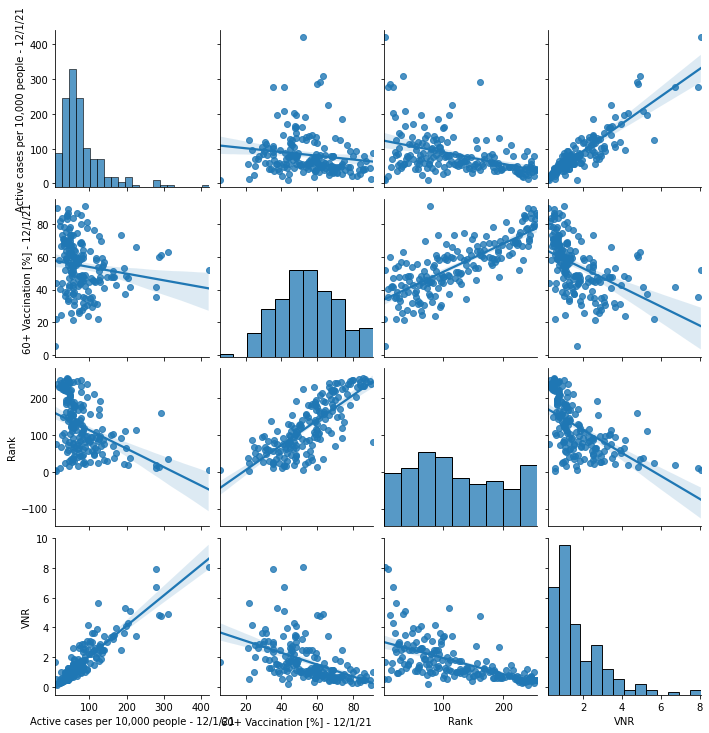

In [60]:
# save original keys for later
x_original = x_key
y_original = y_key

# Calc weights of cities by their relative 60+ population size
total_old_population = bubble_table["population_60+"].sum()
w_key = "weight"
bubble_table[w_key] = (bubble_table["population_60+"] / total_old_population) * 100

# 1) 60+ Vaccinations % ~ Cases per 10000
print("(1) - 60+ Vaccinations % ~ {}".format(x_key.replace('_', ' ')))
calc_correlations(x_key, y_key, w_key)

# 2) 60+ Vaccinations % ~ Socioeconomic Rank
x_key = "Rank"
print("(2) - 60+ Vaccinations % ~ Socioeconomic Rank")
calc_correlations(x_key, y_key, w_key)

# 3) Socioeconomic Rank ~ Cases per 10000
x_key = x_original
y_key = "Rank"
print("(3) - Socioeconomic Rank ~ {}".format(x_key.replace('_', ' ')))
calc_correlations(x_key, y_key, w_key)

# 4) Socioeconomic Rank ~ VNR
x_key = "VNR"
y_key = "Rank"
print("(4) - Socioeconomic Rank ~ {}".format(x_key.replace('_', ' ')))
calc_correlations(x_key, y_key, w_key)

# Correlogram
corr_table = bubble_table.copy()
corr_table = corr_table[[x_original, y_original, 'Rank', 'VNR']]
sns.pairplot(corr_table, kind="reg")
# plt.show()  # need to save manually to .png, .pdf, .svg after setting aspect ratio.

##### Save Results 

In [61]:
# # save to file
# plt.savefig('correlogram.png')
# plt.savefig('correlogram.pdf')
# plt.savefig('correlogram.svg')

# save raw data to csv
processed_data_save_path = os.path.join(PROJECT_PROCESSED_DATA_FOLDER, 'processed_data_merged.csv')
bubble_table.to_csv(processed_data_save_path, encoding='utf-8-sig', index=False)